In [33]:
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature
from scipy.interpolate import InterpolatedUnivariateSpline
import xarray as xr
import geopandas

In [34]:
seasons = [1,2], [4,5], [7,8], [10,11]

In [35]:
months = []
ws = []

In [36]:
for year in np.arange(2000,2001):
	print(year)
	uinfile = Dataset("../../era5/data/{}_100m_u_component_of_wind.nc".format(year))
	vinfile = Dataset("../../era5/data/{}_100m_v_component_of_wind.nc".format(year))

	u = uinfile.variables['u100'][:365*24]
	v = vinfile.variables['v100'][:365*24]
	ws.extend(np.hypot(u,v))
	print(np.shape(ws))

	lons = uinfile.variables['longitude'][:] 
	lats = uinfile.variables['latitude'][:]

	time = uinfile.variables['time']
	times = num2date(time[:365*24], time.units)
	months.extend(np.array([t.month for t in times]))

2000
(8760, 141, 141)


In [37]:
ws = np.array(ws)
months = np.array(months)

In [38]:
capacities = []

turbines = ["Gamesa_G87_2000MW","Vestas_v110_2000MW", "Enercon_E70_2300MW"]

for turbine in turbines:
	
	power_curve = np.genfromtxt('../../energy-model-scripts/extra_files_to_run_scripts/{}_ECEM_turbine.csv'.format(turbine))
	pc_w = power_curve[:,0]
	pc_c = power_curve[:,2]
    
	pc_interpolate = InterpolatedUnivariateSpline(pc_w, pc_c)
	capacity = pc_interpolate(ws)
	
	
	capacities.append(capacity)

In [39]:
capacities = np.array(capacities)
print(capacities.shape)



(3, 8760, 141, 141)


In [40]:
best_turbine = np.argmax(np.mean(capacities,axis=1),axis=0)
print([np.sum(best_turbine==i) for i in range(3)])

[1674, 16671, 1536]


In [41]:
capacity = np.take_along_axis(capacities, best_turbine[None, None, :,:], axis=0).squeeze()

In [42]:
capacity_mean = np.mean(capacity, axis=0)

In [43]:
dstopo = xr.open_dataset("~/geodata/ETOPO1_Ice_c_gmt4.nc")
mask_lon = (dstopo.x >= lons.min()) & (dstopo.x <= lons.max())
mask_lat = (dstopo.y >= lats.min()) & (dstopo.y <= lats.max())
dstopo = dstopo.where(mask_lon & mask_lat, drop=True)

In [44]:
%matplotlib inline
plt.ioff()

fig = plt.figure(figsize=(15,8))

ax1 = plt.subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax2 = plt.subplot(2,4,3, projection=cartopy.crs.PlateCarree())
ax3 = plt.subplot(2,4,4, projection=cartopy.crs.PlateCarree())
ax4 = plt.subplot(2,4,7, projection=cartopy.crs.PlateCarree())
ax5 = plt.subplot(2,4,8, projection=cartopy.crs.PlateCarree())

axes = [ax1,ax2,ax3,ax4,ax5]

cmap_name = 'StepSeq25'
rgb = np.genfromtxt("../other-files/colourmaps/{}.rgb".format(cmap_name))/255.
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb, N=25)

In [45]:
vm=1

cs = ax1.pcolormesh(lons, lats, capacity_mean, cmap=cmap, vmin=0, vmax=vm, rasterized=True)
ax1.contour(dstopo.x, dstopo.y, dstopo.z, levels=[-200], colors=['k',], linestyles=['solid',])

df = geopandas.read_file("/home/users/kieran/geodata/india_states_lores.zip")
df.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=0.25)


fig.subplots_adjust(bottom=0.185, wspace=.1, hspace=.125)
cax = plt.gcf().add_axes([0.175, 0.1, 0.25, 0.025])
cb = plt.colorbar(cs, cax=cax, orientation='horizontal', extend='max')
cb.set_label("Mean hourly capacity factor (optimal turbine)")


print(capacity_mean.min(), capacity_mean.max())


3.886404069099416e-07 0.7342014607213456


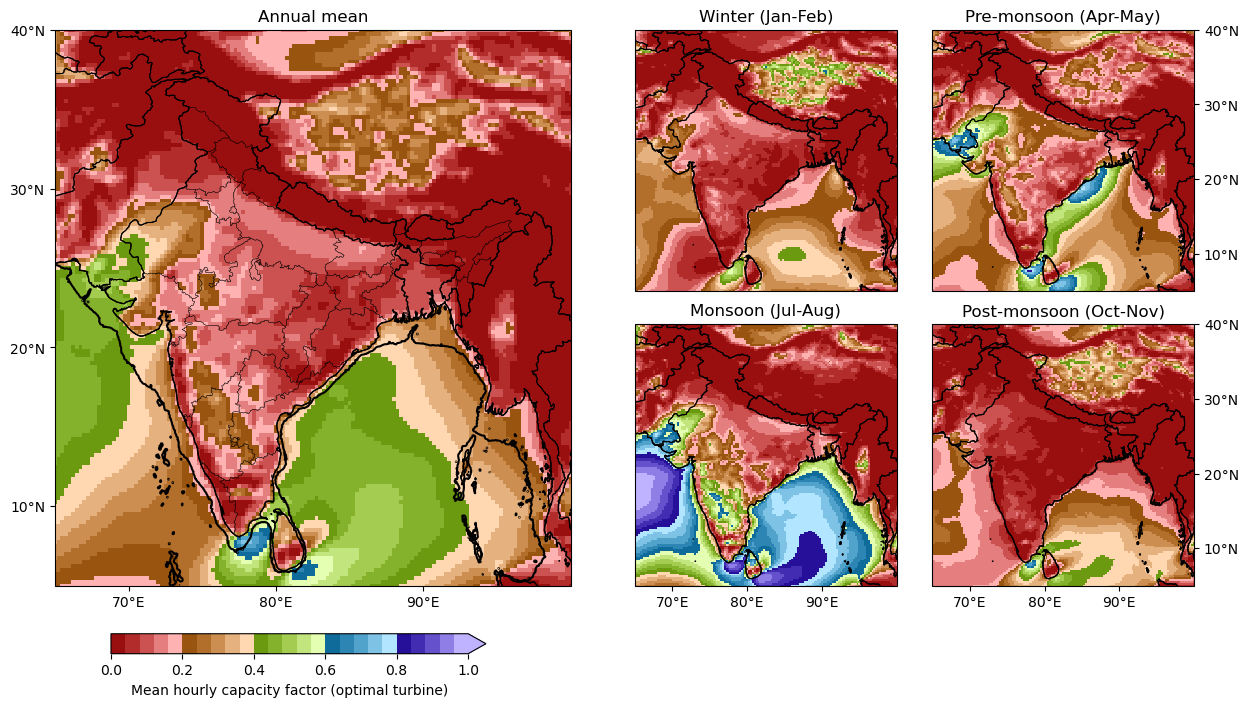

In [46]:
for season, ax in zip(seasons, [ax2,ax3,ax4,ax5]):
	it = np.in1d(months, season)
	capacity_mean = capacity[it].mean(axis=0)
	ax.pcolormesh(lons, lats, capacity_mean, cmap=cmap, vmin=0, vmax=vm, rasterized=True)
	
ax1.set_title("Annual mean")	
ax2.set_title("Winter (Jan-Feb)")	
ax3.set_title("Pre-monsoon (Apr-May)")	
ax4.set_title("Monsoon (Jul-Aug)")	
ax5.set_title("Post-monsoon (Oct-Nov)")	


for ax in ax1, ax4, ax5:
	ax.set_xticks(np.arange(0,100,10))
	ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)

for ax in ax3, ax5:
	ax.set_yticks(np.arange(0,100,10))
	ax.yaxis.tick_right()
	ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax1.set_yticks(np.arange(0,100,10))
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)


shape_feature = ShapelyFeature(shapereader.Reader("/home/users/kieran/geodata/ne_10m_IND_lores/ne_10m_admin_0_countries_ind.shp").geometries(),
                                cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', lw=0.75)


for ax in axes:
	ax.coastlines()
	ax.add_feature(shape_feature)
	ax.set_xlim([lons.min(), lons.max()])
	ax.set_ylim([lats.min(), lats.max()])


plt.show()
